In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

file_path = '/home/gaurav/Desktop/jn/ENB2012_data.xlsx'
data = pd.read_excel(file_path)

data.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
                'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

X = data.iloc[:, :-2]
y = data.iloc[:, -2:]

y_heating = y['Heating_Load']
y_cooling = y['Cooling_Load']

X_train, X_test, y_heating_train, y_heating_test, y_cooling_train, y_cooling_test = train_test_split(
    X, y_heating, y_cooling, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [19]:
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        results[name] = score
        print(f"{name} R^2 score: {score:.4f}")
    return results


Heating Load Model Performance:
Linear Regression R^2 score: 0.9099
Ridge Regression R^2 score: 0.9116
Lasso Regression R^2 score: 0.9046
Random Forest R^2 score: 0.9976
Gradient Boosting R^2 score: 0.9975

Cooling Load Model Performance:
Linear Regression R^2 score: 0.8894
Ridge Regression R^2 score: 0.8928
Lasso Regression R^2 score: 0.8839
Random Forest R^2 score: 0.9679
Gradient Boosting R^2 score: 0.9752


In [22]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2


param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
param_grid_gb = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5]}

best_rf_heating = RandomForestRegressor(random_state=42)
grid_search_rf_heating = GridSearchCV(best_rf_heating, param_grid_rf, cv=5, scoring='r2')
grid_search_rf_heating.fit(X_train_scaled, y_heating_train)
print(f"Best parameters for Random Forest (Heating Load): {grid_search_rf_heating.best_params_}")
print(f"Best R^2 score (Heating Load): {grid_search_rf_heating.best_score_:.4f}")

best_gb_cooling = GradientBoostingRegressor(random_state=42)
grid_search_gb_cooling = GridSearchCV(best_gb_cooling, param_grid_gb, cv=5, scoring='r2')
grid_search_gb_cooling.fit(X_train_scaled, y_cooling_train)
print(f"Best parameters for Gradient Boosting (Cooling Load): {grid_search_gb_cooling.best_params_}")
print(f"Best R^2 score (Cooling Load): {grid_search_gb_cooling.best_score_:.4f}")

best_model_heating = grid_search_rf_heating.best_estimator_
best_model_cooling = grid_search_gb_cooling.best_estimator_

mse_heating, r2_heating = evaluate_model(best_model_heating, X_test_scaled, y_heating_test)
print(f"Heating Load - MSE: {mse_heating:.4f}, R^2: {r2_heating:.4f}")

mse_cooling, r2_cooling = evaluate_model(best_model_cooling, X_test_scaled, y_cooling_test)
print(f"Cooling Load - MSE: {mse_cooling:.4f}, R^2: {r2_cooling:.4f}")

Best parameters for Random Forest (Heating Load): {'max_depth': 10, 'n_estimators': 100}
Best R^2 score (Heating Load): 0.9973
Best parameters for Gradient Boosting (Cooling Load): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best R^2 score (Cooling Load): 0.9876
Heating Load - MSE: 0.2487, R^2: 0.9976
Cooling Load - MSE: 0.8392, R^2: 0.9909


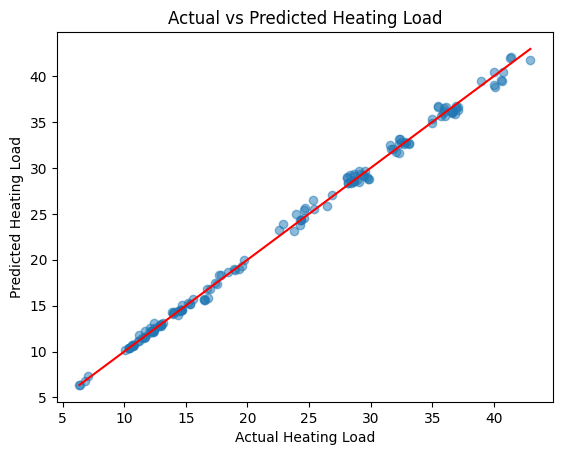

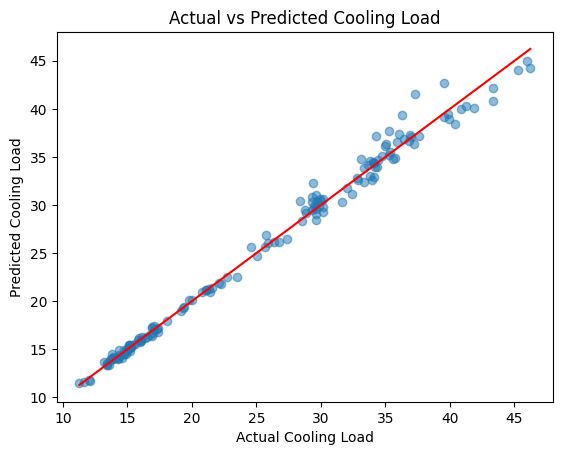

Feature importances for Heating Load (Random Forest):
Relative_Compactness: 0.3864
Surface_Area: 0.1886
Wall_Area: 0.0462
Roof_Area: 0.1355
Overall_Height: 0.1510
Orientation: 0.0007
Glazing_Area: 0.0791
Glazing_Area_Distribution: 0.0124

Feature importances for Cooling Load (Gradient Boosting):
Relative_Compactness: 0.2715
Surface_Area: 0.1952
Wall_Area: 0.0251
Roof_Area: 0.1594
Overall_Height: 0.2806
Orientation: 0.0092
Glazing_Area: 0.0449
Glazing_Area_Distribution: 0.0140

--- Conclusion ---
1. Random Forest was chosen as the best model for Heating Load, and Gradient Boosting for Cooling Load.
2. Hyperparameter tuning was performed to optimize model performance.
3. Feature importance analysis provided insights into the impact of each feature.
4. The best-performing models were saved for future use.
5. Future work could involve further hyperparameter tuning, exploring more complex models, or incorporating additional features.


In [24]:
import joblib

heating_predictions = best_model_heating.predict(X_test_scaled)

plt.scatter(y_heating_test, heating_predictions, alpha=0.5)
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Actual vs Predicted Heating Load')
plt.plot([min(y_heating_test), max(y_heating_test)], [min(y_heating_test), max(y_heating_test)], color='red')
plt.show()

cooling_predictions = best_model_cooling.predict(X_test_scaled)

plt.scatter(y_cooling_test, cooling_predictions, alpha=0.5)
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Cooling Load')
plt.title('Actual vs Predicted Cooling Load')
plt.plot([min(y_cooling_test), max(y_cooling_test)], [min(y_cooling_test), max(y_cooling_test)], color='red')
plt.show()

# Feature importance analysis for Random Forest (Heating Load)
rf_heating_importances = best_model_heating.feature_importances_
print("Feature importances for Heating Load (Random Forest):")
for feature, importance in zip(data.columns[:-2], rf_heating_importances):
    print(f"{feature}: {importance:.4f}")

# Feature importance analysis for Gradient Boosting (Cooling Load)
gb_cooling_importances = best_model_cooling.feature_importances_
print("\nFeature importances for Cooling Load (Gradient Boosting):")
for feature, importance in zip(data.columns[:-2], gb_cooling_importances):
    print(f"{feature}: {importance:.4f}")

joblib.dump(best_model_heating, 'best_model_heating.pkl')
joblib.dump(best_model_cooling, 'best_model_cooling.pkl')

def summarize_findings():
    print("\n--- Conclusion ---")
    print("1. Random Forest was chosen as the best model for Heating Load, and Gradient Boosting for Cooling Load.")
    print("2. Hyperparameter tuning was performed to optimize model performance.")
    print("3. Feature importance analysis provided insights into the impact of each feature.")
    print("4. The best-performing models were saved for future use.")
    print("5. Future work could involve further hyperparameter tuning, exploring more complex models, or incorporating additional features.")

summarize_findings()
